In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [4]:
df = pd.read_csv(os.getcwd()+r"\Data Files\Corpus_MRO.csv", encoding = 'unicode_escape')

In [5]:
df.head()

,spend_group,spend_cat_sim_l1_nestec,spend_cat_sim_l2_nestec,spend_cat_sim_l3_nestec,material_group_master_data,material_group_master_data_desc,material,material_desc,material_descr_from_po,purchasing_org,...,material_type,material_type_desc,base_unit,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2
0,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,** Carbagas/Kohlendioxyd CO2 Flüssiggas,CH10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5012160,Energy-CO2,0010/001718102,CO2,"10,400.42 CHF","10,400.42",24 Industrial Gases
1,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,***UMO ALQUILER UNIDAD CRIOGENICA,ES10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0045/794241001,Gastos comunes fábri,"3,574.48 EUR","3,972.83",24 Industrial Gases
2,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,"**19 - CARBON DIOXIDE, COMPLIANCE TRANSP",US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0076/013893010,Site Supply Chain,"$15,822.53","15,657.73",24 Industrial Gases
3,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**Bulk CO2 Gas,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5014020,Eng. 3rd Part Serv,0042/548919003,TECHNICAL OFFICE,"$1,726.96","1,698.81",24 Industrial Gases
4,S&IM,24 MRO Supplies and Services,24 Industrial Gases,24 CO2 Gas,S240002,24 CO2 Gas,90072571,24 CO2 Gas,**CO2 - BULK CARBON DIOXIDE,US10,...,ZSIM,ZSIM Generic Indir Mat.,EA,N001/5046000,Operating Supplies,0042/587817201,REFRIGERATION,"$8,786.90","8,777.23",24 Industrial Gases


In [6]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2"]
seed = 10

In [7]:
df.label_l2.value_counts()

24 MRO Services                   3566
24 Workshop Equipment&Supplies    1121
24 Industrial Gases                669
Name: label_l2, dtype: int64

In [8]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [9]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [10]:
print("Train sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_train.shape[0],
                                 round((y_train=="24 MRO Services").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Workshop Equipment&Supplies").sum()/y_train.count()*100,2),
                                 round((y_train=="24 Industrial Gases").sum()/y_train.count()*100,2))
     )

print("valid sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_valid.shape[0],
                                 round((y_valid=="24 MRO Services").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Workshop Equipment&Supplies").sum()/y_valid.count()*100,2),
                                 round((y_valid=="24 Industrial Gases").sum()/y_valid.count()*100,2))
     )

print("test sample : %.0f \t 24 MRO Services : %.1f \t 24 Workshop Equipment&Supplies : %.1f \tIndustrial Gases : %.1f" % (X_test.shape[0],
                                 round((y_test=="24 MRO Services").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Workshop Equipment&Supplies").sum()/y_test.count()*100,2),
                                 round((y_test=="24 Industrial Gases").sum()/y_test.count()*100,2))
     )

Train sample : 3427 	 24 MRO Services : 66.9 	 24 Workshop Equipment&Supplies : 20.8 	Industrial Gases : 12.3
valid sample : 857 	 24 MRO Services : 64.8 	 24 Workshop Equipment&Supplies : 21.6 	Industrial Gases : 13.7
test sample : 1072 	 24 MRO Services : 67.0 	 24 Workshop Equipment&Supplies : 21.0 	Industrial Gases : 12.0


# material_descr_from_po

In [11]:
selected_col = "material_descr_from_po"

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train1 = vectorizer.transform(sentences_train)
X_valid1 = vectorizer.transform(sentences_valid)
X_test1  = vectorizer.transform(sentences_test)
X_all = vectorizer.transform(df[selected_col].values)

In [13]:
pd.DataFrame(X_train1.toarray()).head()
vectorizer.vocabulary_

{'screw': 3399,
 'set': 3496,
 'm8': 2586,
 '25': 422,
 '92015a151': 868,
 'diverse': 1661,
 'servicearbeiten': 3470,
 'serviceeinsatz': 3475,
 'daniel': 1575,
 'von': 3947,
 'wulffen': 4042,
 'ups': 3895,
 'service': 3450,
 '2019': 349,
 'lone': 2513,
 'worker': 4031,
 'contract': 1487,
 'oxigenio': 2920,
 'indl': 2235,
 'carga': 1318,
 '01m3': 30,
 'm5': 2556,
 '12': 138,
 'allen': 988,
 'cap': 1304,
 'lock': 2510,
 '85076': 823,
 'grip': 2080,
 'screwdriver': 3403,
 '7pc': 798,
 '6m': 746,
 'walzenstrasse': 3962,
 'stöckli': 3682,
 'azote': 1110,
 'l50': 2424,
 '4m3': 626,
 'calls': 1293,
 'august': 1087,
 'and': 1016,
 'september': 3442,
 'mro': 2761,
 'services': 3485,
 'assemblage': 1066,
 'soudure': 3577,
 'de': 1590,
 'tuy': 3868,
 'tech': 3747,
 'mo': 2720,
 'selon': 3429,
 'ot': 2902,
 's49': 3354,
 'ct2mi': 1540,
 'co2': 1430,
 'liq': 2494,
 'carbon': 1312,
 'dioxide': 1650,
 '3m': 556,
 'verwiegung': 3927,
 'ks1': 2404,
 'robitsch': 3273,
 'gas': 2026,
 'nitrogen': 2811,
 '

## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [14]:
param_grid = {'C':np.exp(np.arange(-6,1,0.01))}

In [15]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 100,
    cv=kfolds.split(X_train1,y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [16]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train1, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Randomized search time: 3.2184271812438965


In [17]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [18]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

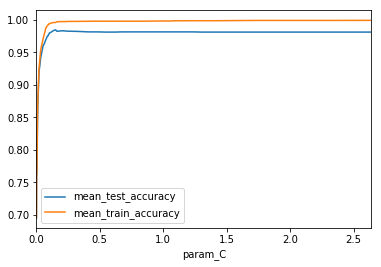

In [19]:
tmp1.plot(x="param_C")

In [20]:
params

{'C': 0.15259010575687046}

## Logistic With optimized Hyperparameters 

In [21]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=0.15)
classifier.fit(X_train1, y_train)
score = classifier.score(X_test1, y_test)


print("Train Accuracy %.3f" % classifier.score(X_train1, y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid1, y_valid))
# print("Test Accuracy %.3f" % classifier.score(X_test1, y_test))


Train Accuracy 0.996
Valid Accuracy 0.987


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [22]:
pred= pd.DataFrame(classifier.predict_proba(X_all), columns = classifier.classes_)

In [23]:
pred.head()

,24 Industrial Gases,24 MRO Services,24 Workshop Equipment&Supplies
0,0.740145,0.128386,0.131469
1,0.447051,0.285337,0.267612
2,0.457124,0.310264,0.232611
3,0.887092,0.052218,0.060690
4,0.794751,0.100776,0.104473


In [24]:
df["24 Industrial Gases_0"]=pred["24 Industrial Gases"]
df["24 MRO Services_0"]=pred["24 MRO Services"]

X_train["24 Industrial Gases_0"]= pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 Industrial Gases"]
X_train["24 MRO Services_0"]=pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 MRO Services"]

X_valid["24 Industrial Gases_0"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 Industrial Gases"]
X_valid["24 MRO Services_0"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 MRO Services"]

X_test["24 Industrial Gases_0"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 Industrial Gases"]
X_test["24 MRO Services_0"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 MRO Services"]



C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

# vendor_desc

In [25]:
selected_col = "vendor_desc"

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train1 = vectorizer.transform(sentences_train)
X_valid1 = vectorizer.transform(sentences_valid)
X_test1  = vectorizer.transform(sentences_test)
X_all = vectorizer.transform(df[selected_col].values)

In [27]:
pd.DataFrame(X_train1.toarray()).head()
vectorizer.vocabulary_

{'mcmaster': 1063,
 'carr': 256,
 'supply': 1579,
 'co': 304,
 'still': 1556,
 'ag': 42,
 'meurer': 1094,
 'verpackungssysteme': 1712,
 'gmbh': 669,
 'enaco': 500,
 'sverige': 1582,
 'ab': 14,
 'sbes': 1430,
 'limited': 960,
 'white': 1756,
 'martins': 1040,
 'gases': 637,
 'industriais': 779,
 'tim': 1634,
 'fatt': 569,
 'hardware': 706,
 'industrial': 780,
 'motion': 1127,
 'industries': 786,
 'inc': 773,
 'wimos': 1762,
 'linde': 961,
 'france': 611,
 'cee': 260,
 'elevator': 489,
 'service': 1466,
 '03': 0,
 'ltd': 989,
 'gangloff': 631,
 'scoma': 1449,
 'bottling': 205,
 'machines': 1001,
 'atlas': 130,
 'kopko': 912,
 'hellas': 721,
 'ae': 37,
 'ct2mi': 370,
 'messer': 1082,
 'llc': 973,
 'infrawerk': 792,
 'thailand': 1623,
 'public': 1336,
 'foynes': 610,
 'engineering': 512,
 'pac': 1219,
 'langen': 936,
 'wray': 1780,
 'mechanical': 1069,
 'acoustics': 29,
 'international': 819,
 'marine': 1031,
 'douglas': 439,
 'machine': 998,
 'wee': 1742,
 'yang': 1787,
 'sdn': 1451,
 'bh

## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [28]:
param_grid = {'C':np.exp(np.arange(-6,3,0.01))}

In [29]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 100,
    cv=kfolds.split(X_train1,y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [30]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train1, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Randomized search..
Randomized search time: 3.376002550125122


In [31]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [32]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

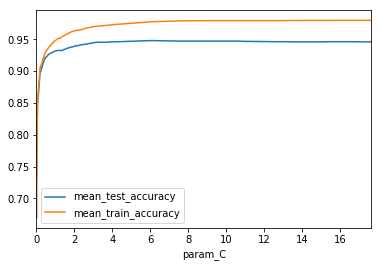

In [33]:
tmp1.plot(x="param_C")

In [34]:
params

{'C': 6.04964746441194}

## Logistic With optimized Hyperparameters 

In [35]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=6.04964746441194)
classifier.fit(X_train1, y_train)
score = classifier.score(X_test1, y_test)


print("Train Accuracy %.3f" % classifier.score(X_train1, y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid1, y_valid))
# print("Test Accuracy %.3f" % classifier.score(X_test1, y_test))


Train Accuracy 0.975
Valid Accuracy 0.960


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [36]:
pred= pd.DataFrame(classifier.predict_proba(X_all), columns = classifier.classes_)

In [37]:
pred.head()

,24 Industrial Gases,24 MRO Services,24 Workshop Equipment&Supplies
0,0.811800,0.182347,0.005853
1,0.980408,0.015467,0.004125
2,0.905958,0.065538,0.028504
3,0.667892,0.043861,0.288247
4,0.667892,0.043861,0.288247


In [38]:
df["24 Industrial Gases_1"]=pred["24 Industrial Gases"]
df["24 MRO Services_1"]=pred["24 MRO Services"]

X_train["24 Industrial Gases_1"]= pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 Industrial Gases"]
X_train["24 MRO Services_1"]=pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 MRO Services"]

X_valid["24 Industrial Gases_1"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 Industrial Gases"]
X_valid["24 MRO Services_1"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 MRO Services"]

X_test["24 Industrial Gases_1"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 Industrial Gases"]
X_test["24 MRO Services_1"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 MRO Services"]



C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

# account_number_desc

In [39]:
selected_col = "account_number_desc"

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train1 = vectorizer.transform(sentences_train)
X_valid1 = vectorizer.transform(sentences_valid)
X_test1  = vectorizer.transform(sentences_test)
X_all = vectorizer.transform(df[selected_col].values)

In [41]:
pd.DataFrame(X_train1.toarray()).head()
vectorizer.vocabulary_

{'operating': 68,
 'supplies': 104,
 'maintenance': 53,
 'repair': 90,
 'eng': 26,
 '3rd': 0,
 'part': 75,
 'serv': 93,
 'mat': 55,
 'spr': 100,
 'prts': 84,
 'lab': 46,
 'materials': 56,
 'energy': 25,
 'co2': 13,
 'nitrogen': 62,
 'n001': 60,
 'not': 64,
 'assigned': 4,
 'other': 71,
 'othr': 72,
 'profession': 82,
 'fees': 34,
 'product': 80,
 'costs': 20,
 'misc': 59,
 'expenses': 31,
 'small': 97,
 'office': 65,
 'equip': 28,
 'outside': 73,
 'srvcs': 102,
 'gen': 39,
 'lease': 48,
 'rent': 89,
 'expense': 30,
 'freight': 36,
 'clearing': 11,
 'mfg': 58,
 'cost': 19,
 'pack': 74,
 'pu': 85,
 'training': 109,
 'external': 32,
 'bldg': 7,
 'landscape': 47,
 'srvc': 101,
 'waste': 115,
 'disposal': 22,
 'raw': 88,
 'pur': 86,
 'brnd': 8,
 'bld': 6,
 'act': 1,
 'trd': 110,
 'environ': 27,
 'safety': 91,
 'non': 63,
 'globe': 40,
 'cogs': 14,
 'stores': 103,
 'issues': 44,
 'invoice': 43,
 'clg': 12,
 'tax': 105,
 'item': 45,
 'comp': 15,
 'cont': 17,
 'oth': 70,
 'prom': 83,
 'audit':

## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [42]:
param_grid = {'C':np.exp(np.arange(-6,5,0.01))}

In [43]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 100,
    cv=kfolds.split(X_train1,y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [44]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train1, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Randomized search time: 3.020953893661499


In [45]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [46]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

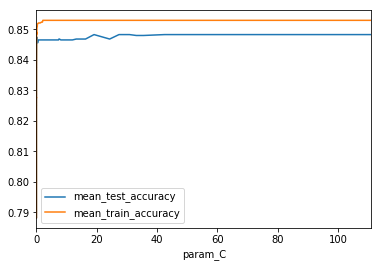

In [47]:
tmp1.plot(x="param_C")

In [48]:
params

{'C': 42.521082000053944}

## Logistic With optimized Hyperparameters 

In [49]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=42.521082000053944)
classifier.fit(X_train1, y_train)
score = classifier.score(X_test1, y_test)


print("Train Accuracy %.3f" % classifier.score(X_train1, y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid1, y_valid))
# print("Test Accuracy %.3f" % classifier.score(X_test1, y_test))


Train Accuracy 0.853
Valid Accuracy 0.848


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [50]:
pred= pd.DataFrame(classifier.predict_proba(X_all), columns = classifier.classes_)

In [51]:
pred.head()

,24 Industrial Gases,24 MRO Services,24 Workshop Equipment&Supplies
0,0.997333,0.002054,0.000614
1,0.254941,0.064832,0.680228
2,0.254941,0.064832,0.680228
3,0.008502,0.989527,0.001971
4,0.254941,0.064832,0.680228


In [52]:
df["24 Industrial Gases_2"]=pred["24 Industrial Gases"]
df["24 MRO Services_2"]=pred["24 MRO Services"]

X_train["24 Industrial Gases_2"]= pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 Industrial Gases"]
X_train["24 MRO Services_2"]=pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 MRO Services"]

X_valid["24 Industrial Gases_2"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 Industrial Gases"]
X_valid["24 MRO Services_2"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 MRO Services"]

X_test["24 Industrial Gases_2"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 Industrial Gases"]
X_test["24 MRO Services_2"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 MRO Services"]



C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

# cost_center_desc

In [53]:
selected_col = "cost_center_desc"

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train1 = vectorizer.transform(sentences_train)
X_valid1 = vectorizer.transform(sentences_valid)
X_test1  = vectorizer.transform(sentences_test)
X_all = vectorizer.transform(df[selected_col].values)

In [55]:
pd.DataFrame(X_train1.toarray()).head()
vectorizer.vocabulary_

{'technical': 440,
 'stores': 425,
 'nrk': 324,
 'site': 408,
 'engineering': 172,
 '0020': 7,
 'not': 320,
 'assigned': 77,
 'roaster': 382,
 'proces': 360,
 '0021': 8,
 'almoxarifado': 64,
 '0012': 2,
 'workshop': 463,
 '0010': 0,
 'labo': 249,
 'cergy': 111,
 'fr': 208,
 'comm': 131,
 '0025': 9,
 '0039': 16,
 '0058': 28,
 'co2': 126,
 '0047': 22,
 '0042': 18,
 '0037': 15,
 '0034': 13,
 'to': 442,
 'chimie': 118,
 '0029': 12,
 'vapor': 454,
 'gastos': 218,
 'comunes': 140,
 '0017': 6,
 '0015': 4,
 'office': 328,
 'soluble': 412,
 'coff': 127,
 'process': 361,
 'general': 219,
 'common': 132,
 'aguas': 58,
 'residuales': 379,
 'factory': 191,
 'chrg': 120,
 '0011': 1,
 'my36': 307,
 'region': 376,
 'clearing': 123,
 'bottling': 88,
 '0014': 3,
 'charges': 113,
 'filling': 196,
 'line': 262,
 'blowmolding': 86,
 'fty': 212,
 'laundry': 259,
 'clothes': 124,
 'cleaning': 121,
 'security': 399,
 'nitrogen': 313,
 'sugar': 427,
 'mfg': 292,
 'laboratorio': 251,
 'fin': 197,
 'goods': 222,

## Logistic Model

## L2 Penalty Hyper Parameter Optimization

In [56]:
param_grid = {'C':np.exp(np.arange(-6,2,0.01))}

In [57]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 100,
    cv=kfolds.split(X_train1,y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [58]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train1, y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Randomized search..
Randomized search time: 2.6639087200164795


In [59]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [60]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

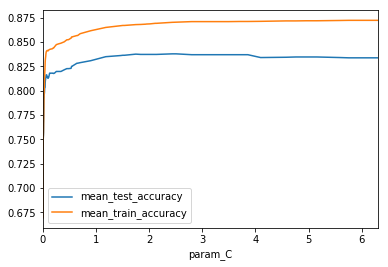

In [61]:
tmp1.plot(x="param_C")

In [62]:
params

{'C': 2.435129651289517}

## Logistic With optimized Hyperparameters 

In [63]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=2.435129651289517)
classifier.fit(X_train1, y_train)
score = classifier.score(X_test1, y_test)


print("Train Accuracy %.3f" % classifier.score(X_train1, y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid1, y_valid))
# print("Test Accuracy %.3f" % classifier.score(X_test1, y_test))


Train Accuracy 0.868
Valid Accuracy 0.823


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [64]:
pred= pd.DataFrame(classifier.predict_proba(X_all), columns = classifier.classes_)

In [65]:
pred.head()

,24 Industrial Gases,24 MRO Services,24 Workshop Equipment&Supplies
0,0.931213,0.047938,0.020849
1,0.799358,0.170325,0.030318
2,0.424284,0.540653,0.035064
3,0.169294,0.067995,0.762710
4,0.714493,0.253326,0.032181


In [66]:
df["24 Industrial Gases_3"]=pred["24 Industrial Gases"]
df["24 MRO Services_3"]=pred["24 MRO Services"]

X_train["24 Industrial Gases_3"]= pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 Industrial Gases"]
X_train["24 MRO Services_3"]=pd.DataFrame(classifier.predict_proba(X_train1), columns = classifier.classes_)["24 MRO Services"]

X_valid["24 Industrial Gases_3"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 Industrial Gases"]
X_valid["24 MRO Services_3"]=pd.DataFrame(classifier.predict_proba(X_valid1), columns = classifier.classes_)["24 MRO Services"]

X_test["24 Industrial Gases_3"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 Industrial Gases"]
X_test["24 MRO Services_3"]=pd.DataFrame(classifier.predict_proba(X_test1), columns = classifier.classes_)["24 MRO Services"]



C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

# Combine all Models

In [67]:
comb_columns = ['24 Industrial Gases_0', '24 MRO Services_0',
       '24 Industrial Gases_1', '24 MRO Services_1', '24 Industrial Gases_2',
       '24 MRO Services_2', '24 Industrial Gases_3', '24 MRO Services_3']

## L2 Penalty Hyper Parameter Optimization

In [68]:
param_grid = {'C':np.exp(np.arange(-6,2,0.01))}

In [69]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l2')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['accuracy'], n_iter = 100,
    cv=kfolds.split(X_train[comb_columns],y_train), verbose=0, random_state=1,
    refit = 'accuracy', return_train_score=True, error_score = 0)

In [70]:
X_train[comb_columns].shape

(3427, 8)

In [71]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(X_train[comb_columns], y_train)
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.2

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

Randomized search time: 3.5404977798461914


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was 

In [72]:
pd.DataFrame(dic).to_csv(r"RCV_results_log_0_l2.csv")

In [73]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_accuracy","mean_train_accuracy"]].sort_values(by = 'param_C')

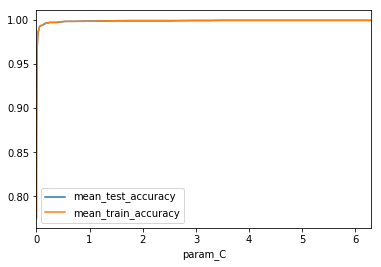

In [74]:
tmp1.plot(x="param_C")

In [75]:
params

{'C': 3.85742553069637}

## Logistic With optimized Hyperparameters 

In [76]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty = 'l2', C=3.85742553069637)
classifier.fit(X_train[comb_columns], y_train)
score = classifier.score(X_test[comb_columns], y_test)


print("Train Accuracy %.3f" % classifier.score(X_train[comb_columns], y_train))
print("Valid Accuracy %.3f" % classifier.score(X_valid[comb_columns], y_valid))
print("Test Accuracy %.3f" % classifier.score(X_test[comb_columns], y_test))


Train Accuracy 0.999
Valid Accuracy 0.994
Test Accuracy 0.997


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [77]:
pred= pd.DataFrame(classifier.predict_proba(df[comb_columns]), columns = classifier.classes_)

In [78]:
pred.head()

,24 Industrial Gases,24 MRO Services,24 Workshop Equipment&Supplies
0,0.996462,0.000090,0.003448
1,0.994641,0.000391,0.004968
2,0.986392,0.001152,0.012456
3,0.944990,0.001590,0.053420
4,0.946212,0.000168,0.053620


In [81]:
model = classifier
all_col = comb_columns

# Model Evaluation Test Data

In [86]:
acc = model.score(X_test[all_col], y_test)

print('Test accuracy:', acc)

Test accuracy: 0.9972014925373134


Confusion matrix, without normalization


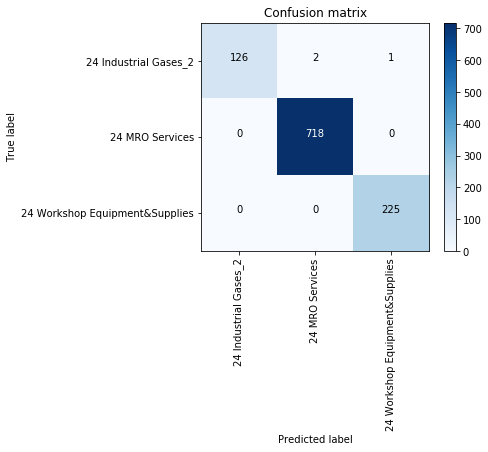

In [92]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test[all_col]);
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(['24 Industrial Gases_2','24 MRO Services','24 Workshop Equipment&Supplies']), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [93]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9943091732729332

In [117]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)
text_labels=['24 Industrial Gases','24 MRO Services','24 Workshop Equipment&Supplies']

score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,1.000000,0.976744,0.988235,129
1,24 MRO Services,0.997222,1.000000,0.998609,718
2,24 Workshop Equipment&Supplies,0.995575,1.000000,0.997783,225


In [118]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_test)


LabelEncoder()

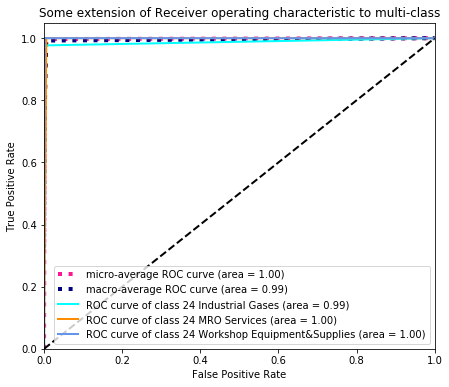

In [121]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from keras.utils import to_categorical

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==text_labels[i]), (y_pred == text_labels[i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(le.transform(y_test)).ravel(), to_categorical(le.transform(y_pred)).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [126]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==text_labels[i]), (y_pred == text_labels[i]))
    average_precision[i] = average_precision_score((y_test==text_labels[i]), (y_pred == text_labels[i]))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(le.transform(y_test)).ravel(), to_categorical(le.transform(y_pred)).ravel())
average_precision["micro"] = average_precision_score(to_categorical(le.transform(y_test)), to_categorical(le.transform(y_pred)),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

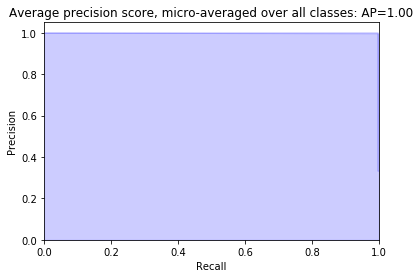

In [127]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

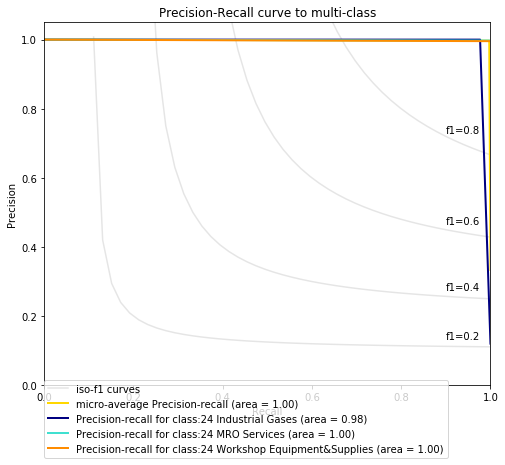

In [128]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()